<a href="https://colab.research.google.com/github/dmassoo/ANLP/blob/main/ANLP_lab4_Dmitrii_Vorotnikov_J41321c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Soft deadline: `30.03.2022 23:59`

In this homework you will understand the fine-tuning procedure and get acquainted with Huggingface Datasets library

In [2]:
! pip install datasets
! pip install transformers

     |████████████████████████████████| 325 kB 11.9 MB/s 
     |████████████████████████████████| 1.1 MB 9.7 MB/s 
     |████████████████████████████████| 212 kB 1.1 MB/s 
     |████████████████████████████████| 134 kB 50.6 MB/s 
     |████████████████████████████████| 67 kB 5.4 MB/s 
     |████████████████████████████████| 127 kB 51.6 MB/s 
     |████████████████████████████████| 94 kB 3.1 MB/s 
     |████████████████████████████████| 271 kB 50.2 MB/s 
     |████████████████████████████████| 144 kB 52.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 3.8 MB 10.5 MB/s 


For our goals we will use [Datasets](https://huggingface.co/docs/datasets/) library and take `yahoo_answers_topics` dataset - the task of this dataset is to divide documents on 10 topic categories. More detiled information can be found on the dataset [page](https://huggingface.co/datasets/viewer/).


In [3]:
from datasets import load_dataset

In [4]:
dataset = load_dataset('yahoo_answers_topics') # the result is a dataset dictionary of train and test splits in this case

Generating train split:   0%|          | 0/1400000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Dataset yahoo_answers_topics downloaded and prepared to /root/.cache/huggingface/datasets/yahoo_answers_topics/yahoo_answers_topics/1.0.0/b2712a72fde278f1d6e96cc4f485fd89ed2f79ecb231441e13645b53da021902. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
dataset.column_names

{'test': ['id', 'topic', 'question_title', 'question_content', 'best_answer'],
 'train': ['id', 'topic', 'question_title', 'question_content', 'best_answer']}

# Fine-tuning the model** (20 points)

In [6]:
from transformers import (ElectraTokenizer, ElectraForSequenceClassification,
                          get_scheduler, pipeline, ElectraForMaskedLM, 
                          ElectraModel, Trainer, TrainingArguments, glue_compute_metrics, InputFeatures)

import torch
from torch.utils.data import DataLoader, Dataset
from datasets import load_metric
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Fine-tuning procedure on the end task consists of adding additional layers on the top of the pre-trained model. The resulting model can be tuned fully (passing gradients through the all model) or partially.

**Task**: 
- load tokenizer and model
- look at the predictions of the model as-is before any fine-tuning


```
- Why don't you ask [MASK]?
- What is [MASK]
- Let's talk about [MASK] physics
```

- convert `best_answer` to the input tokens (supporting function for dataset is provided below) 

```
def tokenize_function(examples):
    return tokenizer(examples["best_answer"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
```

- define optimizer, sheduler (optional)
- fine-tune the model (write the training loop), plot the loss changes and measure results in terms of weighted F1 score
- get the masked word prediction (sample sentences above) on the fine-tuned model, why the results as they are and what should be done in order to change that (write down your answer)
- Tune the training hyperparameters (and write down your results).

**Tips**:
- The easiest way to get predictions is to use transformers `pipeline` function 
- Do not forget to set `num_labels` parameter, when initializing the model
- To convert data to batches use `DataLoader`
- Even the `small` version of Electra can be long to train, so you can take data sample (>= 5000 and set seed for reproducibility)
- You may want to try freezing (do not update the pretrained model weights) all the layers exept the ones for classification, in that case use:


```
for param in model.electra.parameters():
      param.requires_grad = False
```


In [7]:
MODEL_NAME = "google/electra-small-generator"
TOKENIZER_NAME = "google/electra-small-generator"

In [8]:
tokenizer = ElectraTokenizer.from_pretrained(TOKENIZER_NAME)
model = ElectraForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=10)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/662 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/51.7M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/electra-small-generator were not used when initializing ElectraForSequenceClassification: ['generator_predictions.LayerNorm.weight', 'generator_predictions.LayerNorm.bias', 'generator_lm_head.weight', 'generator_predictions.dense.weight', 'generator_lm_head.bias', 'generator_predictions.dense.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-generator and are newly initializ

In [9]:
predictor = pipeline("fill-mask", model=MODEL_NAME)

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [10]:
masked1 = "Why don't you ask [MASK]?"
masked2 = "What is [MASK]?"
masked3 =  "Let's talk about [MASK] physics"

In [11]:
predictor(masked1)[0:2]

[{'score': 0.5342992544174194,
  'sequence': "why don't you ask me?",
  'token': 2033,
  'token_str': 'me'},
 {'score': 0.08196018636226654,
  'sequence': "why don't you ask questions?",
  'token': 3980,
  'token_str': 'questions'}]

In [12]:
predictor(masked2)[0:2]

[{'score': 0.4963124096393585,
  'sequence': 'what is it?',
  'token': 2009,
  'token_str': 'it'},
 {'score': 0.2050585150718689,
  'sequence': 'what is this?',
  'token': 2023,
  'token_str': 'this'}]

In [13]:
predictor(masked3)[0:2]

[{'score': 0.24027501046657562,
  'sequence': "let's talk about quantum physics",
  'token': 8559,
  'token_str': 'quantum'},
 {'score': 0.21258601546287537,
  'sequence': "let's talk about theoretical physics",
  'token': 9373,
  'token_str': 'theoretical'}]

In [14]:
class TrainerDataset(Dataset):
    def __init__(self, inputs, targets, tokenizer):
        self.inputs = inputs
        self.targets = targets
        self.tokenizer = tokenizer
        self.tokenized_inputs = tokenizer(inputs, padding="max_length", truncation=True)   

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return InputFeatures(
            input_ids=self.tokenized_inputs['input_ids'][idx],
            token_type_ids=self.tokenized_inputs['token_type_ids'][idx],
            attention_mask=self.tokenized_inputs['attention_mask'][idx],
            label=self.targets[idx])

In [15]:
N = 5000 # number of samples

In [16]:
train_dataset = TrainerDataset(dataset["train"]["best_answer"][:N],
                               dataset["train"]["topic"][:N], tokenizer)
eval_dataset = TrainerDataset(dataset["test"]["best_answer"][:N],
                              dataset["test"]["topic"][:N], tokenizer)

In [21]:
np.random.seed(42)
torch.manual_seed(42)

training_args = TrainingArguments(
    output_dir='/hw4',
    overwrite_output_dir=True,
    num_train_epochs=5,
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=8,
    dataloader_drop_last=True,
    evaluation_strategy="steps"
)

metric = load_metric('f1')

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    # The choice of a dataset (task_name) implies metric
    return glue_compute_metrics(
        task_name="sst-2",
        preds=preds,
        labels=p.label_ids)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics
    )

using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [22]:
train_info = trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 5000
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3125


Step,Training Loss,Validation Loss,Acc
500,1.490900,1.417672,0.536200
1000,1.223800,1.400861,0.549600
1500,1.091300,1.391179,0.558000
2000,0.943800,1.440213,0.552400
2500,0.828400,1.464981,0.549600
3000,0.713600,1.473748,0.559400


***** Running Evaluation *****
  Num examples = 5000
  Batch size = 8
/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:66: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
Saving model checkpoint to /hw4/checkpoint-500
Configuration saved in /hw4/checkpoint-500/config.j

In [40]:
step_vs_loss = [[500,	1.490900],
[1000,	1.223800],
[1500,	1.091300]	,
[2000,	0.943800]	,
[2500,	0.828400]	,
[3000,	0.713600]]

([2500, 0.8284],)

In [57]:
# plt.plot(step_vs_loss[:][1])
steps = list(map(lambda pair: pair[0], step_vs_loss))
losses = list(map(lambda pair: pair[1], step_vs_loss))

Text(0, 0.5, 'Loss')

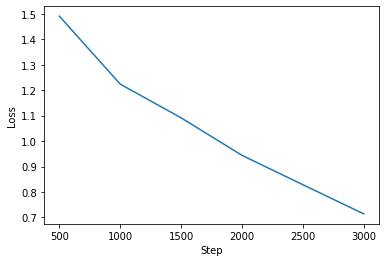

In [59]:
plt.plot(steps, losses)
plt.xlabel("Step")
plt.ylabel("Loss")

In [23]:
tuned_result = trainer.evaluate()
tuned_result

***** Running Evaluation *****
  Num examples = 5000
  Batch size = 8


/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:66: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


{'epoch': 5.0,
 'eval_acc': 0.5576,
 'eval_loss': 1.4750816822052002,
 'eval_runtime': 77.2993,
 'eval_samples_per_second': 64.684,
 'eval_steps_per_second': 8.085}

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
model.save_pretrained("/content/drive/MyDrive/ANLP/hw4/tuned")

Configuration saved in /content/drive/MyDrive/ANLP/hw4/tuned/config.json
Model weights saved in /content/drive/MyDrive/ANLP/hw4/tuned/pytorch_model.bin


In [26]:
fine_model = ElectraForMaskedLM.from_pretrained("/content/drive/MyDrive/ANLP/hw4/tuned")

loading configuration file /content/drive/MyDrive/ANLP/hw4/tuned/config.json
Model config ElectraConfig {
  "_name_or_path": "google/electra-small-generator",
  "architectures": [
    "ElectraForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9"
  },
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8,
    "LABEL_9": 9
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 4,
  "num_hidde

In [29]:
tuned_predictor = pipeline("fill-mask", model=fine_model, tokenizer=tokenizer)

We can observe that results became worse. It is due to the fact we are solving fill-mask problem with the suitable model, but then we tune it to solve topic classification problem. 

In [30]:
tuned_predictor(masked1)[0:2]

[{'score': 0.0003450549265835434,
  'sequence': "why don't you ask aisles?",
  'token': 25442,
  'token_str': 'a i s l e s'},
 {'score': 0.0003081746108364314,
  'sequence': "why don't you askbial?",
  'token': 21102,
  'token_str': '# # b i a l'}]

In [31]:
tuned_predictor(masked2)[0:2]

[{'score': 0.0004607580485753715,
  'sequence': 'what isgree?',
  'token': 28637,
  'token_str': '# # g r e e'},
 {'score': 0.00042730403947643936,
  'sequence': 'what isrial?',
  'token': 14482,
  'token_str': '# # r i a l'}]

In [32]:
tuned_predictor(masked1)[0:3]

[{'score': 0.0003450549265835434,
  'sequence': "why don't you ask aisles?",
  'token': 25442,
  'token_str': 'a i s l e s'},
 {'score': 0.0003081746108364314,
  'sequence': "why don't you askbial?",
  'token': 21102,
  'token_str': '# # b i a l'},
 {'score': 0.0002909075119532645,
  'sequence': "why don't you ask exchequer?",
  'token': 28889,
  'token_str': 'e x c h e q u e r'}]

We should use models tuned for the task we want to solve. Or at least we can fix parameters of basic model, results would remain the same then :)

Talking about hyperparameters, we can change dataset (including its size), number of epochs, batch size, dropout etc